<a href="https://colab.research.google.com/github/the-SQuAD-squad/IR-QA/blob/main/QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Init { form-width: "25%" }
import os
import random
import math
import numpy as np
import tensorflow as tf
import json
import pandas as pd

pd.set_option('display.max_colwidth', -1)

# fix random seeds
seed_value = 42 #@param {type:"integer"}

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#@title df creation { form-width: "25%" }

# dataset is copyed to public git repo for fast access within colab 
!wget 'https://raw.githubusercontent.com/the-SQuAD-squad/data/main/SQuAD/squad1.1.zip'
!unzip -o squad1.1.zip

with open("training_set.json", "r") as f:
    json_file = json.load(f)
data = json_file["data"]

rows = []
for document in data:
  for par in document['paragraphs']:
    for qas in par['qas']:
      rows.append({
        'id' : qas['id'],
        'title': document["title"],
        'passage': par['context'],
        'question' : qas['question'],
        'answer_idx' : (qas['answers'][0]['answer_start'], 
                    qas['answers'][0]['answer_start'] + len(qas['answers'][0]['text'])),
        'answer_text' : qas['answers'][0]['text']
      })

df_original = pd.DataFrame(rows)

--2021-02-03 15:16:13--  https://raw.githubusercontent.com/the-SQuAD-squad/data/main/SQuAD/squad1.1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7638822 (7.3M) [application/zip]
Saving to: ‘squad1.1.zip’

squad1.1.zip        100%[===================>]   7.28M  42.8MB/s    in 0.2s    

2021-02-03 15:16:14 (42.8 MB/s) - ‘squad1.1.zip’ saved [7638822/7638822]

Archive:  squad1.1.zip
  inflating: training_set.json       


In [ ]:
df_original

,id,title,passage,question,answer_idx,answer_text
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?,"(515, 541)",Saint Bernadette Soubirous
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is in front of the Notre Dame Main Building?,"(188, 213)",a copper statue of Christ
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",The Basilica of the Sacred heart at Notre Dame is beside to which structure?,"(279, 296)",the Main Building
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is the Grotto at Notre Dame?,"(381, 420)",a Marian place of prayer and reflection
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mar

In [ ]:
import nltk
import re 
import math

def preprocess_text(text):
    """
    Given an iterable containing sentences, pre-process each sentence.

    :param: 
        - text: list of text to be pre-processed (Iterable)
    :return:
        - text: pre-processed text (List)
    """

    REPLACE_WITH_SPACE = re.compile(r"\n") 
    text = [REPLACE_WITH_SPACE.sub(" ", line) for line in text]

    # we don't remove symbols, but just put a space before and after them. We did this because we noticed that Glove contains an embedding also for
    # them, so, in this way, we are able to split these symbols from the text when computing sentence tokens
    text = [re.sub(r"([(.;:!\'ˈ~?,\"(\[\])\\\/\-–\t```<>_#$€@%*+—°′″“”×’^₤₹‘])", r' \1 ', line) for line in text]

    # we noticed that in the text sometimes we find numbers and the following word merged together (ex: 1980february),
    # so we put a space between the number and the word
    text = [re.sub(r"(\d+)([a-z]+)", r'\1 \2', line) for line in text] 
    text = [re.sub('\s{2,}', ' ', line.strip()) for line in text]   # replacing more than one consecutive blank spaces with only one of them

    return text


# Creating a copy of the original dataframe (we do this because we want to be able to compare the results of our processing with the original data)
df = df_original.copy()

# pre-process passage and question text
df['passage'] = preprocess_text(df_original['passage'])
df['question'] = preprocess_text(df_original['question'])
df['answer_text'] = preprocess_text(df_original['answer_text'])

In [ ]:
import random as rand
# Comparing Original and Pre-Processed
for i in range(3):
    a = rand.randint(0,1000)
    print('ORIGINAL AND PREPROCESSED PASSAGE:')
    print(df_original.iloc[a]['passage'])
    print(df.iloc[a]['passage'])
    
    print()
    print('ORIGINAL AND PREPROCESSED QUESTION:')
    print(df_original.iloc[a]['question'])
    print(df.iloc[a]['question'])
    print()


ORIGINAL AND PREPROCESSED PASSAGE:
In 2015 Beyoncé signed an open letter which the ONE Campaign had been collecting signatures for; the letter was addressed to Angela Merkel and Nkosazana Dlamini-Zuma, urging them to focus on women as they serve as the head of the G7 in Germany and the AU in South Africa respectively, which will start to set the priorities in development funding before a main UN summit in September 2015 that will establish new development goals for the generation.
In 2015 Beyoncé signed an open letter which the ONE Campaign had been collecting signatures for ; the letter was addressed to Angela Merkel and Nkosazana Dlamini - Zuma , urging them to focus on women as they serve as the head of the G7 in Germany and the AU in South Africa respectively , which will start to set the priorities in development funding before a main UN summit in September 2015 that will establish new development goals for the generation .

ORIGINAL AND PREPROCESSED QUESTION:
An important UN summ

In [ ]:
unwanted_rows = set()   # this set will contain the indices of rows containing errors (thus we will remove these rows from the dataframe)
unwanted_id = set()    # this set will contain the IDs of rows containing errors 
word_idx = []   # will contain the start and end indices of each answer in the corresponing passage
impossible_count = 0

for i in df_original.index:

    # extracting one answer and the corresponding passage
    answer = np.array(df["answer_text"][i].split())
    passage = np.array(df["passage"][i].split())

    l = len(answer)
    idx = []    # this list will contain the start and end indices of the answer occurrence in the corresponding passage (these could be more than 1! ex: we find the answer "rome" in 2 distinct positions in the same passage)
    counts = []     # counts will contain how many characters there are before the answer start in the passage
    char_count = 0
    for j in range(len(passage)-l+1):   # for each token in the passage, check if the answer starts from that token
        if (answer == passage[j:j+l]).all():
            idx.append((j, j+l))    # j is the start_index and j+l is the end_index of the answer in the passage
            counts.append(char_count)    # char_count is the count of characters before the start of the answer
        char_count += len(passage[j])
    if len(counts) == 0:    # no answer found in the passage. Probably there is an error in the dataset (for instance the answer is "7", but in the text it is written like "seven")
        unwanted_rows.add(i)
        unwanted_id.add(df_original["id"][i])
        word_idx.append((-1, -1))   # stating that there was an error
        impossible_count+=1

        # printing original question, answer and passage (by using the answer id to find the right dataframe row)
        print(str(df_original["question"][df_original["id"] == df["id"][i]]))
        print(str(df_original['passage'][df_original['id'] == df['id'][i]]))
        print(str(df_original['answer_text'][df_original['id'] == df['id'][i]]))
        print("answer extracted from: {0}".format((df_original['passage'][i][df_original["answer_idx"][i][0]-3:df_original["answer_idx"][i][1]+3])))
        print()

    else:   # answer found in the passage
        # if more than one answer correspondence was found in the passage, we take the one whose start index is nearer the start index given in the dataset 
        # (these 2 starting indices do not match perfectly because we are working on the preoprocessed text, so our starting index is a little bit different from the original)
        n_spaces_original = df_original["passage"][i][:df_original["answer_idx"][i][0]].count(" ")    # counting how many spaces there are in the original passage before the answer
        n_newline_original = df_original["passage"][i][:df_original["answer_idx"][i][0]].count("\n")    # counting how many newline characters there are in the original passage before the answer
        s = np.abs(np.array(counts)-(df["answer_idx"][i][0]-n_spaces_original-n_newline_original))

        if (0 not in s) and len(s)>1:   # in this case the answer was found in the passage, but the start index specified in the dataset is not the right one (it indicates a wrong occurrence of the answer)
            unwanted_rows.add(i)
            unwanted_id.add(df_original["id"][i])
            word_idx.append((-1, -1))   # stating that there was an error
            impossible_count+=1

            print(str(df_original["question"][df_original["id"]==df["id"][i]]))
            print(str(df_original['passage'][df_original['id'] == df['id'][i]]))
            print(str(df_original['answer_text'][df_original['id'] == df['id'][i]]))
            print("answer extracted from: {0}".format((df_original['passage'][i][df_original["answer_idx"][i][0]-3:df_original["answer_idx"][i][1]+3])))
            print()
        else:
            word_idx.append(idx[np.argmin(s)])
            # print(df_original["answer_text"][i])
            # print(passage[idx[np.argmin(s)][0]:idx[np.argmin(s)][1]])

print("The number of rows that we will remove from the dataframe (because contain errors) are {0}".format(impossible_count))

366    What event caused Beyonce's depression?
Name: question, dtype: object
366    LeToya Luckett and Roberson became unhappy with Mathew's managing of the band and eventually were replaced by Farrah Franklin and Michelle Williams. Beyoncé experienced depression following the split with Luckett and Roberson after being publicly blamed by the media, critics, and blogs for its cause. Her long-standing boyfriend left her at this time. The depression was so severe it lasted for a couple of years, during which she occasionally kept herself in her bedroom for days and refused to eat anything. Beyoncé stated that she struggled to speak about her depression because Destiny's Child had just won their first Grammy Award and she feared no one would take her seriously. Beyoncé would later speak of her mother as the person who helped her fight it. Franklin was dismissed, leaving just Beyoncé, Rowland, and Williams.
Name: passage, dtype: object
366    split with Luckett and Rober
Name: answer_text,

In [ ]:
# adding a new column to the dataframe containing the word indices of the answer in the splitted passage
df["word_idx_answer"] = word_idx
df["passage"]=df["passage"].str.lower()
df["question"]=df["question"].str.lower()
df["answer_text"]=df["answer_text"].str.lower()
df

,id,title,passage,question,answer_idx,answer_text,word_idx_answer
0,5733be284776f41900661182,University_of_Notre_Dame,"architecturally , the school has a catholic character . atop the main building ' s gold dome is a golden statue of the virgin mary . immediately in front of the main building and facing it , is a copper statue of christ with arms upraised with the legend "" venite ad me omnes "" . next to the main building is the basilica of the sacred heart . immediately behind the basilica is the grotto , a marian place of prayer and reflection . it is a replica of the grotto at lourdes , france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 . at the end of the main drive ( and in a direct line that connects through 3 statues and the gold dome ) , is a simple , modern stone statue of mary .",to whom did the virgin mary allegedly appear in 1858 in lourdes france ?,"(515, 541)",saint bernadette soubirous,"(103, 106)"
1,5733be284776f4190066117f,University_of_Notre_Dame,"architecturally , the school has a catholic character . atop the main building ' s gold dome is a golden statue of the virgin mary . immediately in front of the main building and facing it , is a copper statue of christ with arms upraised with the legend "" venite ad me omnes "" . next to the main building is the basilica of the sacred heart . immediately behind the basilica is the grotto , a marian place of prayer and reflection . it is a replica of the grotto at lourdes , france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 . at the end of the main drive ( and in a direct line that connects through 3 statues and the gold dome ) , is a simple , modern stone statue of mary .",what is in front of the notre dame main building ?,"(188, 213)",a copper statue of christ,"(38, 43)"
2,5733be284776f41900661180,University_of_Notre_Dame,"architecturally , the school has a catholic character . atop the main building ' s gold dome is a golden statue of the virgin mary . immediately in front of the main building and facing it , is a copper statue of christ with arms upraised with the legend "" venite ad me omnes "" . next to the main building is the basilica of the sacred heart . immediately behind the basilica is the grotto , a marian place of prayer and reflection . it is a replica of the grotto at lourdes , france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 . at the end of the main drive ( and in a direct line that connects through 3 statues and the gold dome ) , is a simple , modern stone statue of mary .",the basilica of the sacred heart at notre dame is beside to which structure ?,"(279, 296)",the main building,"(58, 61)"
3,5733be284776f41900661181,University_of_Notre_Dame,"architecturally , the school has a catholic character . atop the main building ' s gold dome is a golden statue of the virgin mary . immediately in front of the main building and facing it , is a copper statue of christ with arms upraised with the legend "" venite ad me omnes "" . next to the main building is the basilica of the sacred heart . immediately behind the basilica is the grotto , a marian place of prayer and reflection . it is a replica of the grotto at lourdes , france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 . at the end of the main drive ( and in a direct line that connects through 3 statues and the gold dome ) , is a simple , modern stone statue of mary .",what is the grotto at notre dame ?,"(381, 420)",a marian place of prayer and reflection,"(77, 84)"
4,5733be284776f4190066117e,University_of_Notre_Dame,"architecturally , the school has a catholic character . atop the main building ' s gold dome is a golden statue of the virgin mary . immediately in front of the main building and facing it , is a copper statue of christ with arms upraised with the legend "" venite ad me omnes "" . next to the main building is the basilica of the sacred heart . immed

In [ ]:
import numpy as np

def build_vocabulary(text):
    """
    Given a list of words, builds the corresponding word vocabulary and the mappings from words to indices and vice-versa.

    :param: 
        - text: list of words from which we want to build the vocabularies (List)
    :return:
        - idx2word: index to word mapping (Dict)
        - word2idx: word to index mapping (Dict)
        - set_vocab: set of unique terms that build up the vocabulary
    """

    # Creating a set to eliminate repeated words
    set_vocab = ['<PAD>']+sorted(set(text)) # here we add the padding token as the first element of the set

    # Creating a mapping from unique words to indices
    word2idx = {u:i for i, u in enumerate(set_vocab)}   # the padding token will have 0 index
    # Creating a mapping from indices to unique words
    idx2word = {i:u for i, u in enumerate(set_vocab)}

    return idx2word,word2idx,set_vocab

# Creating a list containing all the passage and question text splitted in words
text =  ' '.join(np.concatenate((df['passage'],df['question']))).split(' ')
# Displaying first 100 words
print(text[:100])
# calling the build_vocabulary function to obtain the vocab and the mappings
idx_to_word, word_to_idx, word_listing = build_vocabulary(text)

print('[Debug] Index -> Word vocabulary size: {}'.format(len(idx_to_word)))
print('[Debug] Word -> Index vocabulary size: {}'.format(len(word_to_idx)))
print('[Debug] Some words: {}'.format([(idx_to_word[idx], idx) for idx in np.arange(100)]))

['architecturally', ',', 'the', 'school', 'has', 'a', 'catholic', 'character', '.', 'atop', 'the', 'main', 'building', "'", 's', 'gold', 'dome', 'is', 'a', 'golden', 'statue', 'of', 'the', 'virgin', 'mary', '.', 'immediately', 'in', 'front', 'of', 'the', 'main', 'building', 'and', 'facing', 'it', ',', 'is', 'a', 'copper', 'statue', 'of', 'christ', 'with', 'arms', 'upraised', 'with', 'the', 'legend', '"', 'venite', 'ad', 'me', 'omnes', '"', '.', 'next', 'to', 'the', 'main', 'building', 'is', 'the', 'basilica', 'of', 'the', 'sacred', 'heart', '.', 'immediately', 'behind', 'the', 'basilica', 'is', 'the', 'grotto', ',', 'a', 'marian', 'place', 'of', 'prayer', 'and', 'reflection', '.', 'it', 'is', 'a', 'replica', 'of', 'the', 'grotto', 'at', 'lourdes', ',', 'france', 'where', 'the', 'virgin', 'mary']
[Debug] Index -> Word vocabulary size: 82630
[Debug] Word -> Index vocabulary size: 82630
[Debug] Some words: [('<PAD>', 0), ('!', 1), ('"', 2), ('#', 3), ('$', 4), ('%', 5), ('&', 6), ("'", 7)

In [ ]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type, embedding_dimension=50):
    """
    Loads a pre-trained word embedding model via gensim library.

    :params:
        - model_type: name of the word embedding model to load.
        - embedding_dimension: size of the embedding space to consider

    :return:
        - pre-trained word embedding model (gensim KeyedVectors object)
    """

    download_path = ""

    # Find the correct embedding model name
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove")

    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model


def check_OOV_terms(embedding_model, word_listing):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :params:
        - embedding_model: pre-trained word embedding model (gensim wrapper)
        - word_listing: dataset specific vocabulary (list)

    :return:
        - list of OOV terms
    """
    # Creating a list for the OOV words
    oov = []
    for word in word_listing:
        # Checking if the word is in the embedding_model
        if word not in embedding_model:
            oov.append(word)
    return oov


def build_embedding_matrix_w_random(embedding_model, embedding_dimension, word_to_idx, oov_terms):
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :params: 
        - embedding_model: pre-trained word embedding model (gensim wrapper)
        - word_to_idx: vocabulary map (word -> index) (dict)
        - oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = []
    for word in word_to_idx:
        if word in oov_terms:
            embedding_matrix.append(np.random.rand(embedding_dimension))
        else:
             embedding_matrix.append(embedding_model[word])
    return np.array(embedding_matrix)

# we used Glove with embedding dimension 100 for our final tests
embedding_model_type = "Glove"
embedding_dimension = 100
embedding_model = load_embedding_model(embedding_model_type, embedding_dimension)

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
# checking how many OOV terms we have
oov_terms = check_OOV_terms(embedding_model, word_listing)

print("Total OOV terms: {0} ({1:.2f}%)".format(len(oov_terms), len(oov_terms)/len(word_listing)*100))

embedding_matrix = build_embedding_matrix_w_random(embedding_model, embedding_dimension, word_to_idx, oov_terms)

print("Embedding matrix shape: {}".format(embedding_matrix.shape))

Total OOV terms: 15985 (19.35%)
Embedding matrix shape: (82630, 100)


In [ ]:
print(oov_terms)   # this was useful to understand if we could improve pre-processing

['<PAD>', '0000222556', '000a', '000rmb', '0018', '0028', '0029670', '0042', '0043', '0054', '0065', '0071', '0079', '00794', '00b7', '00e9', '012f', '0243', '0307', '0358', '036', '042', '057', '058', '05946', '062', '064', '066', '067', '069', '073', '078', '079', '083', '085', '088', '096', '097', '0fm', '100l', '10217', '10925', '10ffff', '10z', '10¢', '10−10', '10−12', '10−19', '10−2', '10−3', '10−34', '10−6', '10−8', '10−9', '1101010', '11092', '11114', '11172', '11246', '12232', '12291', '122ad', '1234567', '12750', '130h', '130j', '131\u202f000', '133cs', '13500', '13526', '13818', '145a', '146a', '14fdr', '14−17', '15408', '16041', '16384', '177847', '178b', '17½', '17\u202f000', '180ad', '18578', '1881−82', '1911a1', '1967a', '1967b', '197bc', '19n', '19sc111', '19˚n', '19˚s', '1fm', '1n4148', '1q08', '1\u202f800', '1⁄10', '1⁄14', '1⁄2', '1⁄3', '1⁄4', '1⁄8', '20011', '20012', '20015', '2002…', '2013−14', '20147', '2053b', '20740', '20gb', '20\u202f000', '21⁄32', '22300', '230

In [ ]:
for i,question in enumerate(df['question']):
    if len(question)<=10:
        print(df_original.iloc[i]) 
        print(df_original['passage'][i])
        print()
        unwanted_rows.add(i)
        unwanted_id.add(df["id"][i])

id             56e6eb396fe0821900b8ec24                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [ ]:
# ERROR CHECK before removing rows
print("Number of errors found: {0}\n".format(str(len(unwanted_id))))
some_error_id = random.sample(unwanted_id, 5)
for id in some_error_id:
    row_with_error = df_original[df_original["id"] == id].to_dict("list")
    print("Question: {0}".format(row_with_error["question"][0]))
    print("Passage: {0}".format(row_with_error["passage"][0]))
    print("Answer: {0}".format(row_with_error["answer_text"][0]))
    print("Answer extracted from: {0}".format(row_with_error["passage"][0][row_with_error["answer_idx"][0][0]-3:row_with_error["answer_idx"][0][1]+3]))
    print()

Number of errors found: 235

Question: How many seats are in the Legislative Council of Saint Helena?
Passage: There are fifteen seats in the Legislative Council of Saint Helena, a unicameral legislature, in addition to a Speaker and a Deputy Speaker. Twelve of the fifteen members are elected in elections held every four years. The three ex officio members are the Chief Secretary, Financial Secretary and Attorney General. The Executive Council is presided over by the Governor, and consists of three ex officio officers and five elected members of the Legislative Council appointed by the Governor. There is no elected Chief Minister, and the Governor acts as the head of government. In January 2013 it was proposed that the Executive Council would be led by a "Chief Councillor" who would be elected by the members of the Legislative Council and would nominate the other members of the Executive Council. These proposals were put to a referendum on 23 March 2013 where they were defeated by 158 

In [ ]:
# Creating a txt file containing IDs of rows with errors for tutors
with open("error IDs.txt", "a") as f:
    for error_id in unwanted_id:
        f.write(error_id + "\n")

In [ ]:
df

,id,title,passage,question,answer_idx,answer_text,word_idx_answer
0,5733be284776f41900661182,University_of_Notre_Dame,"architecturally , the school has a catholic character . atop the main building ' s gold dome is a golden statue of the virgin mary . immediately in front of the main building and facing it , is a copper statue of christ with arms upraised with the legend "" venite ad me omnes "" . next to the main building is the basilica of the sacred heart . immediately behind the basilica is the grotto , a marian place of prayer and reflection . it is a replica of the grotto at lourdes , france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 . at the end of the main drive ( and in a direct line that connects through 3 statues and the gold dome ) , is a simple , modern stone statue of mary .",to whom did the virgin mary allegedly appear in 1858 in lourdes france ?,"(515, 541)",saint bernadette soubirous,"(103, 106)"
1,5733be284776f4190066117f,University_of_Notre_Dame,"architecturally , the school has a catholic character . atop the main building ' s gold dome is a golden statue of the virgin mary . immediately in front of the main building and facing it , is a copper statue of christ with arms upraised with the legend "" venite ad me omnes "" . next to the main building is the basilica of the sacred heart . immediately behind the basilica is the grotto , a marian place of prayer and reflection . it is a replica of the grotto at lourdes , france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 . at the end of the main drive ( and in a direct line that connects through 3 statues and the gold dome ) , is a simple , modern stone statue of mary .",what is in front of the notre dame main building ?,"(188, 213)",a copper statue of christ,"(38, 43)"
2,5733be284776f41900661180,University_of_Notre_Dame,"architecturally , the school has a catholic character . atop the main building ' s gold dome is a golden statue of the virgin mary . immediately in front of the main building and facing it , is a copper statue of christ with arms upraised with the legend "" venite ad me omnes "" . next to the main building is the basilica of the sacred heart . immediately behind the basilica is the grotto , a marian place of prayer and reflection . it is a replica of the grotto at lourdes , france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 . at the end of the main drive ( and in a direct line that connects through 3 statues and the gold dome ) , is a simple , modern stone statue of mary .",the basilica of the sacred heart at notre dame is beside to which structure ?,"(279, 296)",the main building,"(58, 61)"
3,5733be284776f41900661181,University_of_Notre_Dame,"architecturally , the school has a catholic character . atop the main building ' s gold dome is a golden statue of the virgin mary . immediately in front of the main building and facing it , is a copper statue of christ with arms upraised with the legend "" venite ad me omnes "" . next to the main building is the basilica of the sacred heart . immediately behind the basilica is the grotto , a marian place of prayer and reflection . it is a replica of the grotto at lourdes , france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 . at the end of the main drive ( and in a direct line that connects through 3 statues and the gold dome ) , is a simple , modern stone statue of mary .",what is the grotto at notre dame ?,"(381, 420)",a marian place of prayer and reflection,"(77, 84)"
4,5733be284776f4190066117e,University_of_Notre_Dame,"architecturally , the school has a catholic character . atop the main building ' s gold dome is a golden statue of the virgin mary . immediately in front of the main building and facing it , is a copper statue of christ with arms upraised with the legend "" venite ad me omnes "" . next to the main building is the basilica of the sacred heart . immed

In [ ]:
df_clean = df.drop(list(unwanted_rows))
df_clean = df_clean.reset_index()
df_clean.to_pickle("df_clean.pkl")
!zip df_clean.pkl.zip df_clean.pkl
df_clean

  adding: df_clean.pkl (deflated 88%)


,index,id,title,passage,question,answer_idx,answer_text,word_idx_answer
0,0,5733be284776f41900661182,University_of_Notre_Dame,"architecturally , the school has a catholic character . atop the main building ' s gold dome is a golden statue of the virgin mary . immediately in front of the main building and facing it , is a copper statue of christ with arms upraised with the legend "" venite ad me omnes "" . next to the main building is the basilica of the sacred heart . immediately behind the basilica is the grotto , a marian place of prayer and reflection . it is a replica of the grotto at lourdes , france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 . at the end of the main drive ( and in a direct line that connects through 3 statues and the gold dome ) , is a simple , modern stone statue of mary .",to whom did the virgin mary allegedly appear in 1858 in lourdes france ?,"(515, 541)",saint bernadette soubirous,"(103, 106)"
1,1,5733be284776f4190066117f,University_of_Notre_Dame,"architecturally , the school has a catholic character . atop the main building ' s gold dome is a golden statue of the virgin mary . immediately in front of the main building and facing it , is a copper statue of christ with arms upraised with the legend "" venite ad me omnes "" . next to the main building is the basilica of the sacred heart . immediately behind the basilica is the grotto , a marian place of prayer and reflection . it is a replica of the grotto at lourdes , france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 . at the end of the main drive ( and in a direct line that connects through 3 statues and the gold dome ) , is a simple , modern stone statue of mary .",what is in front of the notre dame main building ?,"(188, 213)",a copper statue of christ,"(38, 43)"
2,2,5733be284776f41900661180,University_of_Notre_Dame,"architecturally , the school has a catholic character . atop the main building ' s gold dome is a golden statue of the virgin mary . immediately in front of the main building and facing it , is a copper statue of christ with arms upraised with the legend "" venite ad me omnes "" . next to the main building is the basilica of the sacred heart . immediately behind the basilica is the grotto , a marian place of prayer and reflection . it is a replica of the grotto at lourdes , france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 . at the end of the main drive ( and in a direct line that connects through 3 statues and the gold dome ) , is a simple , modern stone statue of mary .",the basilica of the sacred heart at notre dame is beside to which structure ?,"(279, 296)",the main building,"(58, 61)"
3,3,5733be284776f41900661181,University_of_Notre_Dame,"architecturally , the school has a catholic character . atop the main building ' s gold dome is a golden statue of the virgin mary . immediately in front of the main building and facing it , is a copper statue of christ with arms upraised with the legend "" venite ad me omnes "" . next to the main building is the basilica of the sacred heart . immediately behind the basilica is the grotto , a marian place of prayer and reflection . it is a replica of the grotto at lourdes , france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 . at the end of the main drive ( and in a direct line that connects through 3 statues and the gold dome ) , is a simple , modern stone statue of mary .",what is the grotto at notre dame ?,"(381, 420)",a marian place of prayer and reflection,"(77, 84)"
4,4,5733be284776f4190066117e,University_of_Notre_Dame,"architecturally , the school has a catholic character . atop the main building ' s gold dome is a golden statue of the virgin mary . immediately in front of the main building and facing it , is a copper statue of christ with arms upraised with the legend "" venite ad me omnes "" . next to the main building is the basilica of the sacr

In [ ]:
# PADDING
# all sequences in train and val sets will be padded with a number of tokens equal to the maximum sentence length 
MAX_LENGTH_PASSAGE = len(max(df_clean['passage'], key=len))   
passages = [[word_to_idx[el] for el in sentence.split()] for sentence in df_clean['passage']]  # passages extraction
passages_pad = tf.keras.preprocessing.sequence.pad_sequences(passages, maxlen=MAX_LENGTH_PASSAGE, padding='post') # padding passages

MAX_LENGTH_QUESTION = len(max(df_clean['question'], key=len))   
questions = [[word_to_idx[el] for el in sentence.split()] for sentence in df_clean['question']]  # questions extraction
questions_pad = tf.keras.preprocessing.sequence.pad_sequences(questions, maxlen=MAX_LENGTH_QUESTION, padding='post') # padding questions

df_clean['passage_pad'] = list(passages_pad)
df_clean['question_pad'] = list(questions_pad)

In [3]:
#@title Skip preprocessing
import pickle
load= True #@param {type: "boolean"}

if load:
    import os
    import random
    import math 
    import numpy as np
    import tensorflow as tf
    import json
    import pandas as pd
    import matplotlib.pyplot as plt

    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project feisty-mechanic-221914
    !gsutil cp gs://squad_squad/df_clean.pkl ./df_clean.pkl
    !gsutil cp gs://squad_squad/embedding_matrix.pkl ./embedding_matrix.pkl
    !gsutil cp gs://squad_squad/idx_to_word.pkl ./idx_to_word.pkl

    df_clean = pd.read_pickle("df_clean.pkl")
    with open('embedding_matrix.pkl', 'rb') as handle:
        embedding_matrix = pickle.load(handle)
    with open('idx_to_word.pkl', 'rb') as handle:
        idx_to_word = pickle.load(handle)
else:
    df_clean.to_pickle("df_clean.pkl")
    with open('embedding_matrix.pkl', 'wb') as handle:
        pickle.dump(embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('idx_to_word.pkl', 'wb') as handle:
        pickle.dump(idx_to_word, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project feisty-mechanic-221914
    !gsutil cp ./df_clean.pkl gs://squad_squad/df_clean.pkl
    !gsutil cp ./embedding_matrix.pkl gs://squad_squad/embedding_matrix.pkl
    !gsutil cp ./idx_to_word.pkl gs://squad_squad/idx_to_word.pkl

Updated property [core/project].
Copying gs://squad_squad/df_clean.pkl...
Sliced download tracker file doesn't match for download of ./df_clean.pkl. Restarting download from scratch.
- [1 files][  1.4 GiB/  1.4 GiB]   57.8 MiB/s                                   
Operation completed over 1 objects/1.4 GiB.                                      
Copying gs://squad_squad/embedding_matrix.pkl...
- [1 files][ 63.0 MiB/ 63.0 MiB]                                                
Operation completed over 1 objects/63.0 MiB.                                     
Copying gs://squad_squad/idx_to_word.pkl...
/ [1 files][  1.1 MiB/  1.1 MiB]                                                
Operation completed over 1 objects/1.1 MiB.                                      


In [4]:
#@title split { form-width: "25%" }

split_value = 0.1 #@param {type:"number"} 
val_dim = int(len(df_clean['title'].unique()) * split_value)
val_titles = np.random.choice(df_clean['title'].unique(), size=val_dim, replace=False)

In [5]:
# creating train and val sets
df_val = df_clean[df_clean['title'].isin(val_titles)]
df_train = df_clean[~(df_clean['title'].isin(val_titles))]

In [6]:
input_size=len(idx_to_word)
embedding_dim=100
passage_length = len(df_clean['passage_pad'][0])
question_length = len(df_clean['question_pad'][0])
encoding_units = 128
dropout = 0

input_passage = tf.keras.layers.Input(shape=[None])
input_question = tf.keras.layers.Input(shape=[None])

# EMBEDDING
embedding = tf.keras.layers.Embedding(input_size,
                                    embedding_dim,  
                                    weights=[embedding_matrix],
                                    trainable=False,
                                    mask_zero=True
                                    )   # trainable param is False because we use pre-trained Glove embeddings, mask_zero param is True because we have padding
embedding_passage = embedding(input_passage)
embedding_question = embedding(input_question)


# ENCODING passage AND question
encoding_passage = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(encoding_units, 
                            kernel_initializer='glorot_uniform',
                            recurrent_initializer='orthogonal',
                            dropout=dropout,
                            stateful=False,
                            return_sequences=True))(embedding_passage)    # return_sequences param is True because we want to keep all the hidden states
encoding_question = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(encoding_units, 
                            kernel_initializer='glorot_uniform',
                            recurrent_initializer='orthogonal',
                            dropout=dropout,
                            stateful=False,
                            return_sequences=False))(embedding_question)

# ATTENTION LAYER
#encoded_question = tf.keras.layers.RepeatVector(MAX_LENGTH_PASSAGE)(encoding_question)
query_value_attention_seq = tf.keras.layers.Attention()([encoding_passage, encoding_question])   # out shape: [batch_size, passage_len, encoding_dim]
# reducing over the sequence axis to produce encodings of shape [batch_size, encoding_dimension]
#query_value_attention_seq = tf.keras.layers.GlobalAveragePooling1D()(query_value_attention_seq)
# concatenating passage and question encodings on the sequence length dimension
#encoded_pair = tf.keras.layers.concatenate([encoding_passage, encoding_question],axis=1)
# reducing over the sequence axis to produce encodings of shape [batch_size, encoding_dimension]
#encoded_pair = tf.keras.layers.GlobalAveragePooling1D()(encoded_pair)   
# concatenating passage and question encoding pair with the attention result
#combined = tf.keras.layers.concatenate([encoded_pair, query_value_attention_seq])

output_start = tf.keras.layers.Dense(1)(query_value_attention_seq) # this last dense layer outputs the positive class probability
output_start = tf.keras.layers.Reshape((passage_length,))(output_start)
output_start=tf.keras.layers.Softmax()(output_start)

output_start_reshaped = tf.keras.layers.Reshape((passage_length,1))(output_start)







combined = tf.keras.layers.concatenate([query_value_attention_seq, output_start_reshaped])

lstm_end = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(encoding_units, 
                            kernel_initializer='glorot_uniform',
                            recurrent_initializer='orthogonal',
                            dropout=dropout,
                            stateful=False,
                            return_sequences=True))(combined)

output_end = tf.keras.layers.Dense(1)(lstm_end) # this last dense layer outputs the positive class probability
output_end = tf.keras.layers.Reshape((passage_length,))(output_end)
output_end=tf.keras.layers.Softmax()(output_end)



model = tf.keras.Model([input_passage,input_question], outputs=[output_start, output_end])  
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    8263000     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 256)    234496      embedding[0][0]              

In [ ]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

x_values = np.linspace(-4, 4, 9)
mu,sig = 0,2
kernel = gaussian(x_values, mu, sig)

In [ ]:
y_train = np.zeros((len(df_train['word_idx_answer']), passage_length, 2))
for i,el in enumerate(df_train['word_idx_answer']):
    y_train[i,el[0],0] = 1
    y_train[i,el[1],1] = 1
    #if el[0] < len(kernel)//2:
    #    kernel_eff = kernel[len(kernel)//2-el[0]:]
    #elif el[0] + len(kernel)//2+1 > MAX_LENGTH_PASSAGE:
    #    kernel_eff = kernel[:,el[0] + len(kernel)//2+1- MAX_LENGTH_PASSAGE]
    #else:
    #    kernel_eff = kernel

    #y_train[i,max(0,el[0]-len(kernel)//2) : el[0]+len(kernel)//2+1,0] = kernel_eff

    #if el[1] < len(kernel)//2:
    #    kernel_eff = kernel[len(kernel)//2-el[1]:]
    #elif el[1] + len(kernel)//2+1 > MAX_LENGTH_PASSAGE:
    #    kernel_eff = kernel[:,el[1] + len(kernel)//2+1- MAX_LENGTH_PASSAGE]
    #else:
    #    kernel_eff = kernel

    #y_train[i,max(0,el[1]-len(kernel)//2) : el[1]+len(kernel)//2+1,1] = kernel_eff

y_val = np.zeros((len(df_val['word_idx_answer']), passage_length, 2))
for i,el in enumerate(df_val['word_idx_answer']):
    y_val[i,el[0],0] = 1
    y_val[i,el[1],1] = 1

In [ ]:
cc = tf.keras.losses.CategoricalCrossentropy()

def custom_loss(y_true, y_pred):
    return cc(y_true, y_pred)

saveDir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

chkpt = saveDir + '/squad_check.hdf5'

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Precision'])   # we would like to monitor the accuracy of our classification
es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
cp_cb = tf.keras.callbacks.ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
history = model.fit([np.stack(df_train['passage_pad']),np.stack(df_train['question_pad'])],[y_train[:,:,0],y_train[:,:,1]], epochs=1,
                        callbacks=[es_cb, cp_cb], validation_data=([np.stack(df_val['passage_pad']), np.stack(df_val['question_pad'])],[y_val[:,:,0], y_val[:,:,1]]),
                        batch_size=16)

4831/4831 [==============================] - 466s 93ms/step - loss: 0.0023 - softmax_loss: 0.0012 - softmax_1_loss: 0.0011 - softmax_precision: 0.3198 - softmax_1_precision_1: 0.2709 - val_loss: 0.0024 - val_softmax_loss: 0.0012 - val_softmax_1_loss: 0.0012 - val_softmax_precision: 0.0000e+00 - val_softmax_1_precision_1: 0.3125

Epoch 00001: val_loss improved from inf to 0.00241, saving model to /content/saved_models/squad_check.hdf5


In [ ]:
history = model.fit([np.stack(df_train['passage_pad']),np.stack(df_train['question_pad'])],[y_train[:,:,0],y_train[:,:,1]], epochs=1,
                        callbacks=[es_cb, cp_cb], validation_data=([np.stack(df_val['passage_pad']), np.stack(df_val['question_pad'])],[y_val[:,:,0], y_val[:,:,1]]),
                        batch_size=16)

4831/4831 [==============================] - 444s 92ms/step - loss: 7.2364 - softmax_loss: 3.7148 - softmax_1_loss: 3.5216 - softmax_precision: 0.4167 - softmax_1_precision_1: 0.5152 - val_loss: 7.4837 - val_softmax_loss: 3.8648 - val_softmax_1_loss: 3.6189 - val_softmax_precision: 0.1765 - val_softmax_1_precision_1: 0.0000e+00

Epoch 00001: val_loss improved from 7.54225 to 7.48368, saving model to /content/saved_models/squad_check.hdf5


In [ ]:
df_val['question_pad']

3780     [78803, 15595, 36334, 72453, 75750, 69003, 332...
3781     [36334, 78803, 15595, 38079, 72453, 75750, 497...
3782     [78803, 15595, 33233, 9395, 12947, 72453, 1921...
3783     [78803, 5085, 15595, 78612, 72453, 41745, 5137...
3784     [72453, 44583, 30245, 28780, 36089, 33233, 939...
                               ...                        
85766    [7371, 78803, 7670, 34560, 78272, 72453, 24347...
85767    [34976, 45089, 46739, 8020, 29453, 72453, 4557...
85768    [78803, 21610, 24347, 78162, 73211, 9228, 2288...
85769    [78803, 19690, 72453, 24347, 55868, 36334, 275...
85770    [36334, 78803, 80139, 21610, 24347, 58248, 724...
Name: question_pad, Length: 10075, dtype: object

In [ ]:
predictions=model.predict([np.stack(df_val['passage_pad']), np.stack(df_val['question_pad'])])
sampled=np.argmax(predictions, axis=-1)

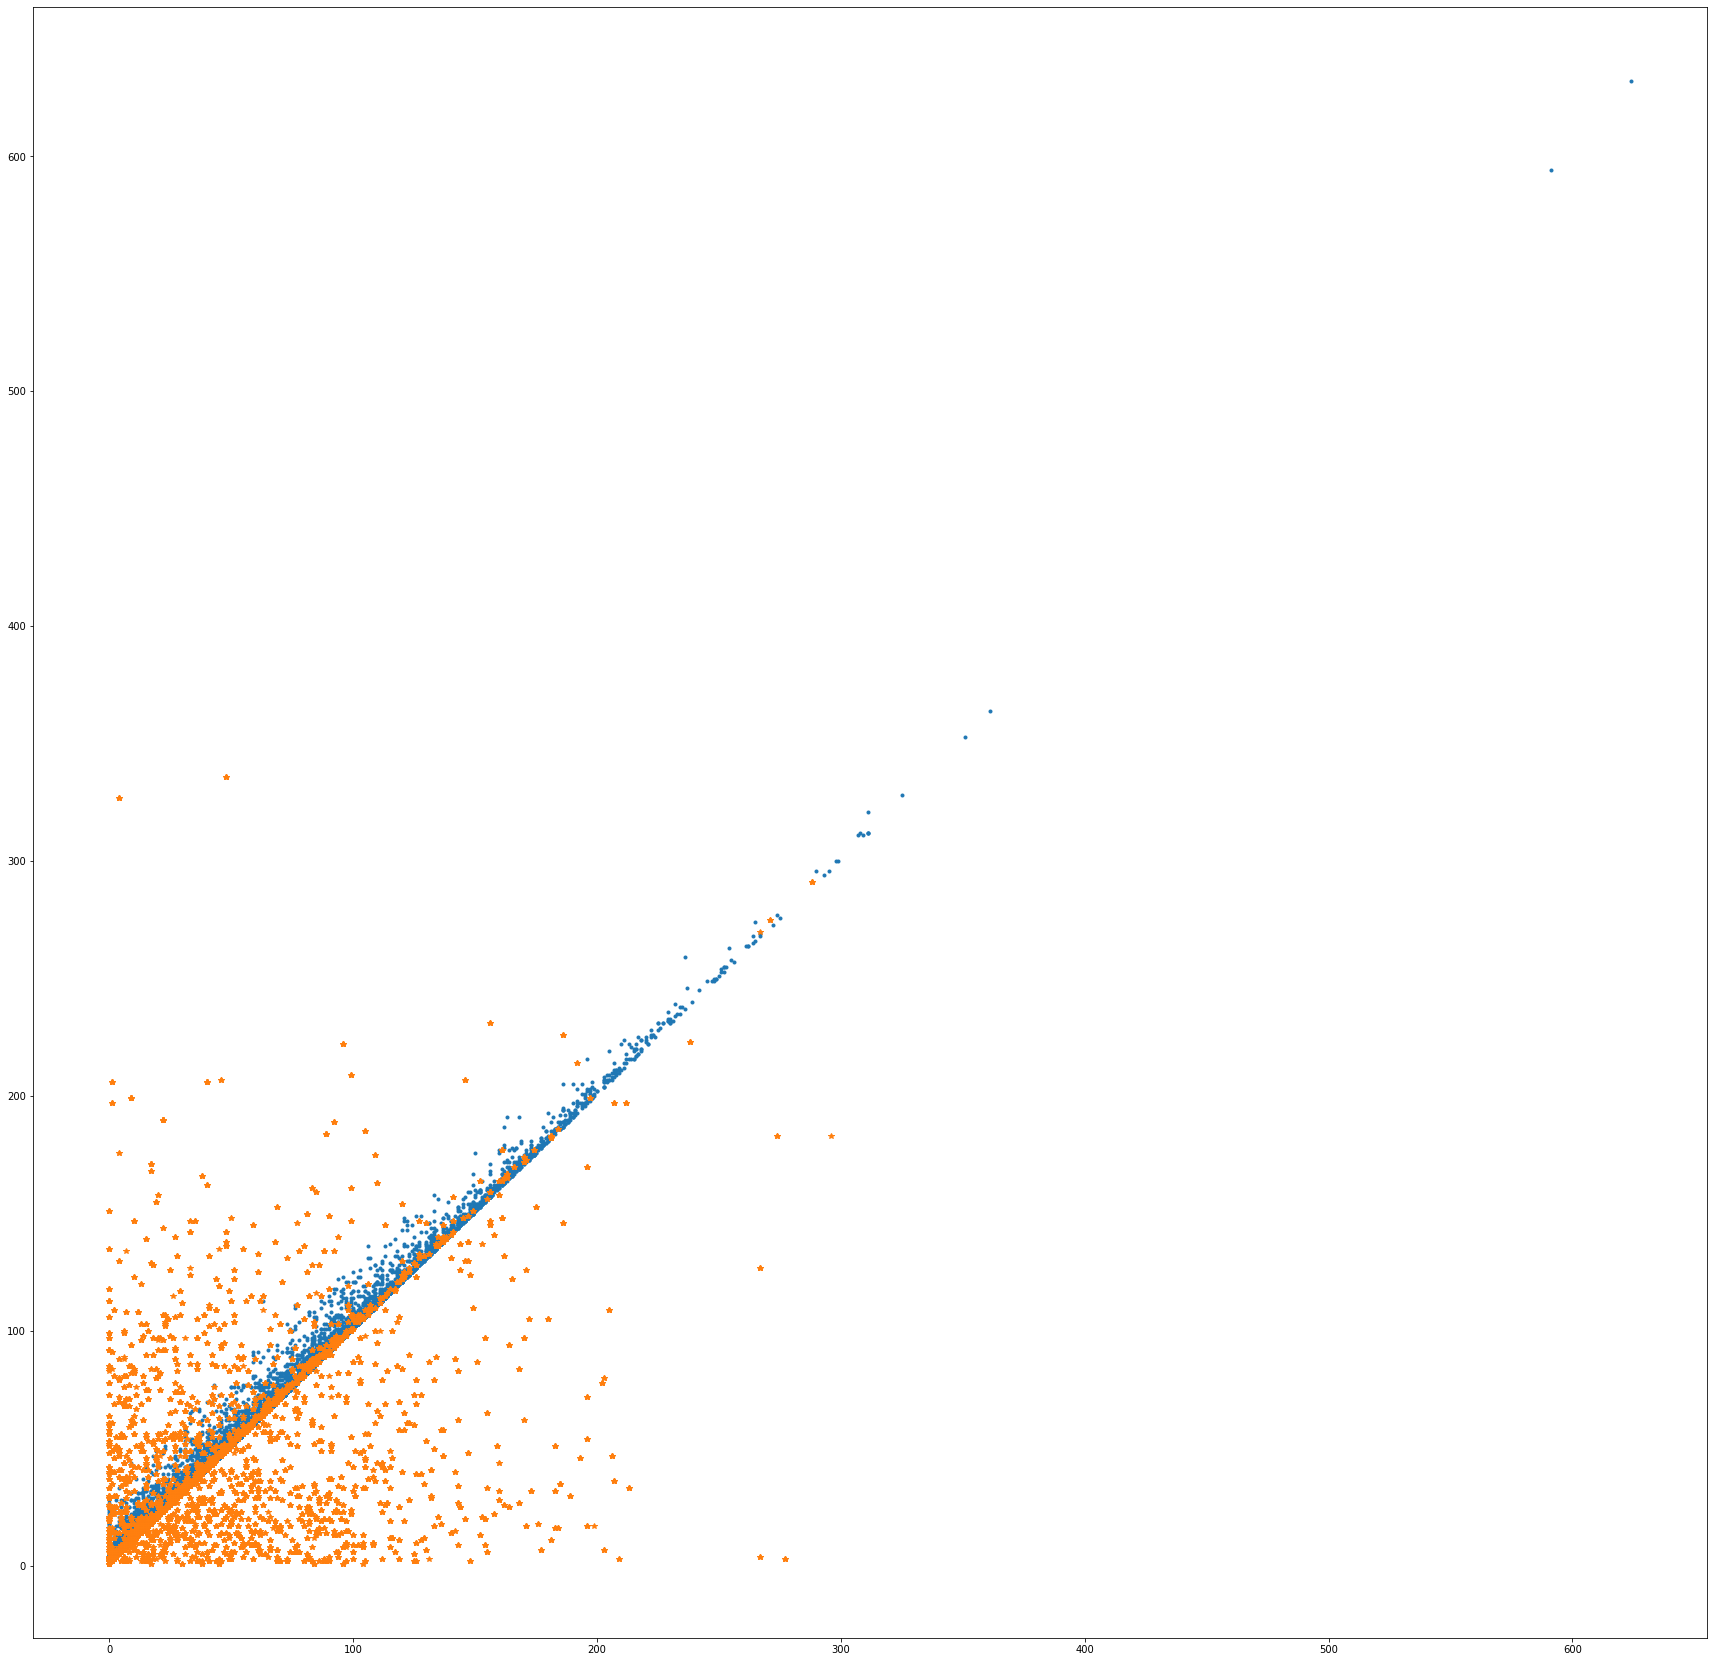

In [ ]:
plt.figure(figsize=(30,30))
plt.plot(np.stack(df_val['word_idx_answer'])[:,0],np.stack(df_val['word_idx_answer'])[:,1], ".")
plt.plot(sampled[0], sampled[1],"*")

In [ ]:
 sum(np.stack(df_val['word_idx_answer'])[:,0] - sampled[0] == 0) / len(np.stack(df_val['word_idx_answer'])[:,0]) 

0.09885856079404466

In [ ]:
predictions=model.predict([np.stack(df_train['passage_pad']), np.stack(df_train['question_pad'])])
sampled=np.argmax(predictions, axis=-1)
sum(np.stack(df_train['word_idx_answer'])[:,0] - sampled[0] == 0) / len(np.stack(df_train['word_idx_answer'])[:,0]) 

0.11407832938710553